In [3]:
# Load ImageNet bar data (binary correctness matrix)
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configure path
IMAGENET_NPY = 'bars/imagenet.npy'
THRESHOLD = 0.6  # keep consistent with other notebooks

bar_data = {}

if not os.path.exists(IMAGENET_NPY):
    raise FileNotFoundError(f'Missing file: {IMAGENET_NPY}')

raw = np.load(IMAGENET_NPY)
# Handle NaNs before thresholding if raw is float
if np.issubdtype(raw.dtype, np.floating):
    raw = np.nan_to_num(raw, nan=0.0)

# Convert to boolean correctness matrix
if raw.dtype == np.bool_:
    B = raw.astype(np.uint8)
else:
    B = (raw > THRESHOLD).astype(np.uint8)

print('Loaded ImageNet bar matrix:')
print('  shape (models, images):', B.shape)
print('  dtype:', B.dtype)

true_acc = B.mean(axis=1)
print('  true_acc range:', float(true_acc.min()), 'to', float(true_acc.max()))


Loaded ImageNet bar matrix:
  shape (models, images): (1023, 50000)
  dtype: uint8
  true_acc range: 0.5791 to 0.90052


Estimating accuracies (fuzzy binary search): 100%|██████████| 1023/1023 [00:00<00:00, 2351.56it/s]


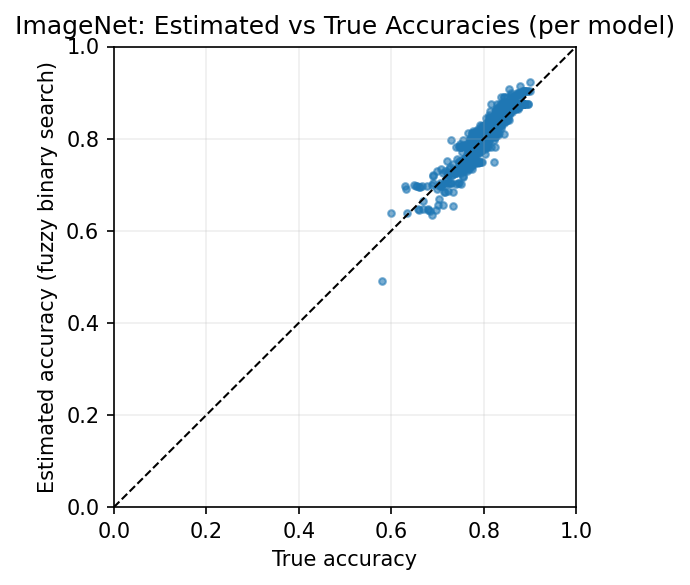

In [4]:
# Fuzzy binary-search accuracy estimation
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

NEIGHBORS = 20  # nearest neighbors window size (5 on each side)


def fuzzy_check_neighborhood(row: np.ndarray, idx: int, neighbors: int = NEIGHBORS) -> float:
    n = row.shape[0]
    half = neighbors // 2
    left_start = max(0, idx - half)
    left_end = idx
    right_start = idx + 1
    right_end = min(n, idx + 1 + half)

    vals = []
    if left_start < left_end:
        vals.append(row[left_start:left_end])
    if right_start < right_end:
        vals.append(row[right_start:right_end])
    if len(vals) == 0:
        return float(row[idx])
    window = np.concatenate(vals, axis=0)
    return float(window.mean())


def estimate_accuracy_row_binary_search(row: np.ndarray, neighbors: int = NEIGHBORS) -> float:
    n = row.shape[0]
    low, high = 0, n - 1
    best_true_idx = -1
    while low <= high:
        mid = (low + high) // 2
        local_mean = fuzzy_check_neighborhood(row, mid, neighbors)
        if local_mean > 0.5:
            best_true_idx = mid
            low = mid + 1
        else:
            high = mid - 1
    return (best_true_idx + 1) / n if best_true_idx >= 0 else 0.0


num_models = B.shape[0]
true_acc = B.mean(axis=1)
est_acc = np.zeros(num_models, dtype=np.float64)

for i in tqdm(range(num_models), desc='Estimating accuracies (fuzzy binary search)'):
    est_acc[i] = estimate_accuracy_row_binary_search(B[i].astype(np.uint8), neighbors=NEIGHBORS)

# Plot estimated vs true accuracies
plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(true_acc, est_acc, s=10, alpha=0.6)
lims = [0, 1]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('True accuracy')
plt.ylabel('Estimated accuracy (fuzzy binary search)')
plt.title('ImageNet: Estimated vs True Accuracies (per model)')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


## K-value analysis

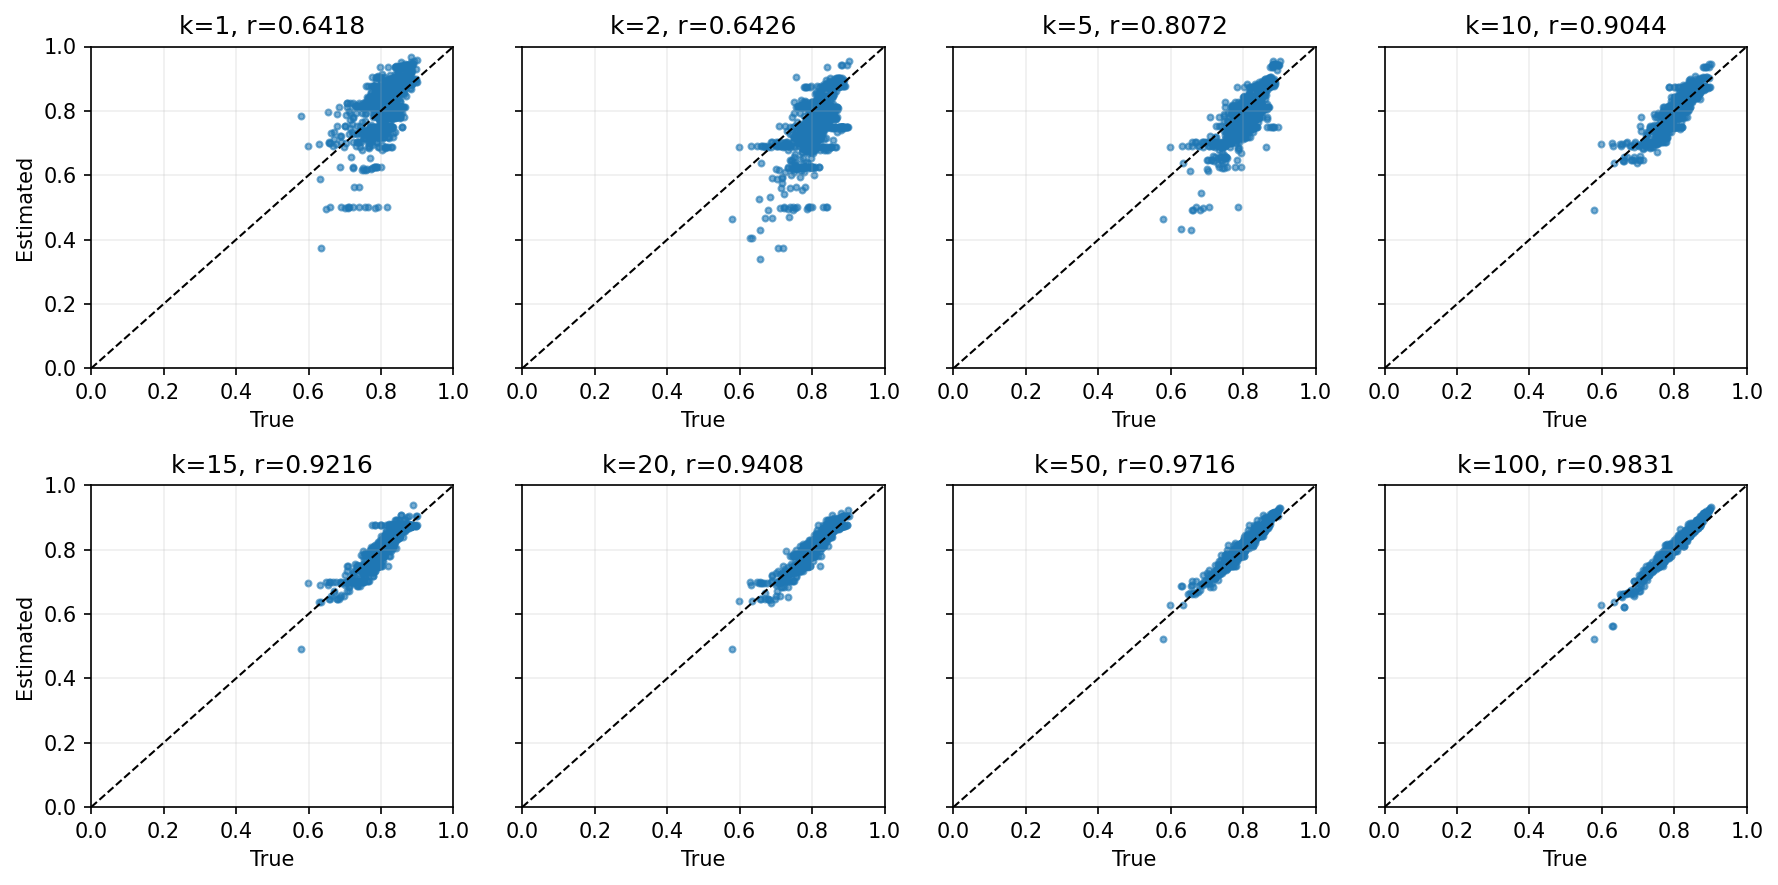

In [5]:
# Compare neighbor window sizes and correlation
import numpy as np
import matplotlib.pyplot as plt

neighbor_values = [1, 2, 5, 10, 15, 20, 50, 100]
num_models = B.shape[0]

fig, axes = plt.subplots(2, 4, figsize=(12, 6), dpi=150)
axes = axes.flatten()

for ax_idx, k in enumerate(neighbor_values):
    est_acc_k = np.zeros(num_models, dtype=np.float64)
    for i in range(num_models):
        est_acc_k[i] = estimate_accuracy_row_binary_search(B[i].astype(np.uint8), neighbors=k)
    r = float(np.corrcoef(true_acc, est_acc_k)[0, 1])

    ax = axes[ax_idx]
    ax.scatter(true_acc, est_acc_k, s=8, alpha=0.6)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"k={k}, r={r:.4f}")
    if ax_idx % 4 == 0:
        ax.set_ylabel('Estimated')
    else:
        ax.set_yticklabels([])
    ax.set_xlabel('True')
    ax.grid(True, alpha=0.2)

# Hide the unused subplot (8th)
for j in range(len(neighbor_values), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## K vs r

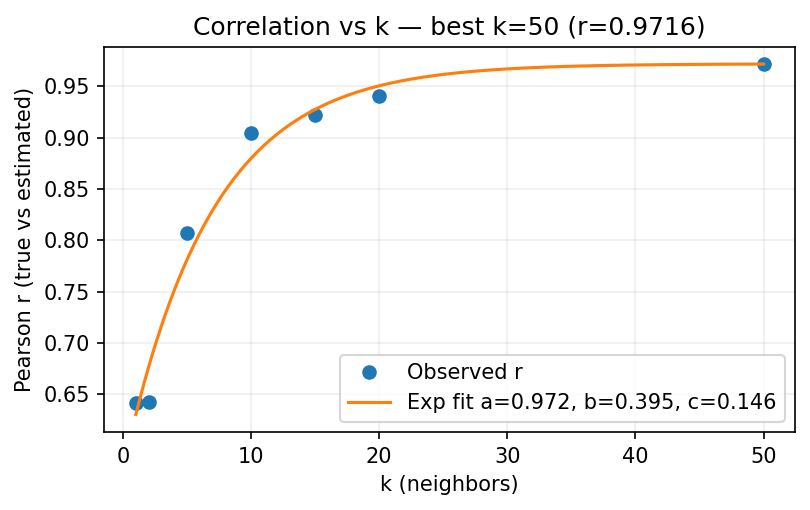

In [ ]:
# Analyze correlation vs k and fit diminishing-returns exponential curve
import numpy as np
import matplotlib.pyplot as plt

neighbor_values = [1, 2, 5, 10, 15, 20, 50]
rs = []
num_models = B.shape[0]

for k in neighbor_values:
    est_acc_k = np.zeros(num_models, dtype=np.float64)
    for i in range(num_models):
        est_acc_k[i] = estimate_accuracy_row_binary_search(B[i].astype(np.uint8), neighbors=k)
    r = float(np.corrcoef(true_acc, est_acc_k)[0, 1])
    rs.append(r)

# Best observed
best_idx = int(np.argmax(rs))
best_k = neighbor_values[best_idx]
best_r = rs[best_idx]

# Fit a saturating inverse-exponential: r(k) = a - b * exp(-c * k)
# We'll sweep 'a' in (max(rs), 1.0] and solve for b,c via linear regression on log(a - r)
ks = np.array(neighbor_values, dtype=float)
rs_arr = np.array(rs, dtype=float)
max_r = float(np.max(rs_arr))

def fit_exp_saturating(ks, rs_arr, a_candidates):
    best = None
    for a in a_candidates:
        # a must be greater than all r values
        if a <= max_r + 1e-9:
            continue
        diff = a - rs_arr
        if np.any(diff <= 0):
            continue
        y = np.log(diff)
        # y = ln b - c * k  => slope = -c, intercept = ln b
        slope, intercept = np.polyfit(ks, y, 1)
        c = -slope
        if c <= 0:
            continue
        b = np.exp(intercept)
        pred = a - b * np.exp(-c * ks)
        sse = float(np.sum((rs_arr - pred) ** 2))
        if (best is None) or (sse < best[0]):
            best = (sse, a, b, c)
    return best

# Candidate 'a' grid
a_grid = np.linspace(max_r + 1e-4, 1.0, 400)
best_fit = fit_exp_saturating(ks, rs_arr, a_grid)

plt.figure(figsize=(5.5, 3.5), dpi=150)
plt.plot(neighbor_values, rs, 'o', label='Observed r')

if best_fit is not None:
    _, a_opt, b_opt, c_opt = best_fit
    xs = np.linspace(min(neighbor_values), max(neighbor_values), 300)
    ys = a_opt - b_opt * np.exp(-c_opt * xs)
    plt.plot(xs, ys, '-', label=f'Exp fit a={a_opt:.3f}, b={b_opt:.3f}, c={c_opt:.3f}')
else:
    plt.plot(neighbor_values, rs, '-', label='No valid exp fit')

plt.xlabel('k (neighbors)')
plt.ylabel('Pearson r (true vs estimated)')
plt.title(f'Correlation vs k — best k={best_k} (r={best_r:.4f})')
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()